In [247]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
np.random.seed(42)

In [187]:
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.metrics import classification_report

https://medium.com/stanford-cs224w/graph-neural-networks-for-knowledge-tracing-ef31fdaa5f00

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df=pd.read_pickle('appmath.pkl')  

In [5]:
df2=pd.read_csv('prereq_edges.csv')

In [6]:
G=nx.Graph()

for _,i in df2.iterrows():    
       
        G.add_edge(i['source_lo_title'],i['dest_lo_title'])
        
subgraphs=[G.subgraph(i) for i in nx.connected_components(G)]

for num,sub in enumerate(subgraphs):
    
    nx.set_node_attributes(sub,num,'subGraphId')

nodeSubGraphId={}
for g in subgraphs:
    for node in g.nodes(data=True):
         nodeSubGraphId[node[0]]= node[1]['subGraphId']
            
subgraphsNodeCountDict={ num: g.number_of_nodes() for num,g in  enumerate(subgraphs)}

In [7]:
for col in df.columns:
    if df[col].dtype.name=='category':
        df[col]=df[col].astype(str)

In [8]:
df['loGraphID']=df.learning_objective_name.apply(lambda x: nodeSubGraphId.get(x) )

In [9]:
difficulty=df[~df.correct.isna()].groupby('atom_id')['correct'].mean().reset_index().rename(columns={'correct':'difficulty'})

In [10]:
difficulty

,atom_id,difficulty
0,000361fc-3126-4f25-93da-3ee3b66021c4,0.571429
1,000785e5-46df-4d0b-a12d-2283db4b8c7f,1.000000
2,000da431-9e35-4309-a3ae-cca9225b8d54,0.638554
3,00170926-4ba4-4d1e-bd86-0ac94107acb1,0.700000
4,001cfd36-68fa-4d74-b077-769f3bf2e0ad,0.712919
...,...,...
16441,fff0e6fc-e78f-41da-bcc8-88a6dceb6cc3,0.581481
16442,fff4801c-d828-453e-b1d4-64369f7b1048,0.666667
16443,fff652bc-b348-4054-9aab-8e67b98b022a,0.714286
16444,fffbe876-95cc-4dd0-9097-c657f446df6a,0.714286


In [11]:
df=df.merge(difficulty,how='left',on='atom_id')

In [12]:
loIndex={lo:i for i,lo in enumerate( df.learning_objective_name.unique())}
df['loIndex']=df['learning_objective_name'].apply(lambda x: loIndex[x])


#df2['source_index']=df2.source_lo_title.map(loIndex)
#df2['dest_index']=df2.dest_lo_title.map(loIndex)

#df2=df2[['source_index','dest_index']].reset_index(drop=True)
#loEdgeIndex=loEdgeMapping.values.transpose()

In [13]:
#df2[(df2.source_lo_title.isin( df.learning_objective_name.unique()[:5])) | (df2.dest_lo_id.isin( df.learning_objective_name.unique()[:5]))]

In [14]:
#loEdgeMapping=df2[['source_index','dest_index']].reset_index(drop=True)
#loEdgeMapping=loEdgeMapping.dropna(axis=0)
#loEdgeIndex=loEdgeMapping.values.transpose()

In [15]:
#loEdgeIndex

In [16]:
#atomIndex={atomId:num for num,atomId in enumerate( df.atom_id.to_list())}

In [17]:
#df['atomIndex']=df.atom_id.apply(lambda x : atomIndex[x] )

In [18]:
def atomClassifier(x):
    if x==None:
        return 'learningMaterial'
    else:
        return 'question'

In [19]:
df['atom_type']=df.correct.apply(lambda x:atomClassifier(x) )

In [20]:
df['correctBinary']=df.correct*1
df.atom_id=df.atom_id.astype(str)


In [114]:
def user_dataset(df,df2,user,goal):
    
    '''
    df - df should be filtered by goal id
    
    edges
    -------
    lo -> atom
    atom -> atom
    lo -> learning materials (lm)
    atom -> lm
    lm -> atom
    lm -> lm
    
    node / features
    ---------------
    
    lo - radnom number
    atom - dificulty , number of attempt
    lm - time spend 
        
    '''    
    df=df[(df.loGraphID==goal) & (df.user_id==user )   ].reset_index(drop=True)
    userDf=df.sort_values(by='interaction_end_time')
    loIndex={lo:i for i,lo in enumerate( userDf.learning_objective_name.unique())}
    
    
    userDf['loIndex']=userDf['learning_objective_name'].apply(lambda x: loIndex[x])
    
    unique_lo=df2[(df2.source_lo_title.isin( df.learning_objective_name.unique())) | (df2.dest_lo_id.isin( df.learning_objective_name.unique()))]
    
    unique_lo['source_index']=unique_lo.source_lo_title.map(loIndex)
    unique_lo['dest_index']=unique_lo.dest_lo_title.map(loIndex)
    
    loEdgeMapping=unique_lo[['source_index','dest_index']].reset_index(drop=True)
    loEdgeMapping=loEdgeMapping.dropna(axis=0)
    loEdgeIndex=loEdgeMapping.values.transpose()
    
    #userDf=df[df.user_id==user]    
    
    
    atomIndex={atomId:num for num,atomId in enumerate( userDf[userDf.atom_type=='question'].atom_id.to_list())}
    lmIndex={atomId:num for num,atomId in enumerate( userDf[userDf.atom_type=='learningMaterial'].atom_id.to_list())}
    
    # assisgning questions and learningMaterials index seperatly in sinlge columns 'atom_index'
    userDf.loc[userDf.atom_type=='question','atomIndex']=userDf.loc[userDf.atom_type=='question',:].atom_id.apply(lambda x : atomIndex[x] )
    userDf.loc[userDf.atom_type=='learningMaterial','atomIndex']=userDf.loc[userDf.atom_type=='learningMaterial',:].atom_id.apply(lambda x : lmIndex[x] )
    
    #lo-atom
    loAtomEdgeIndex=userDf[userDf.atom_type=='question'][['loIndex','atomIndex']].values.transpose()
    #lo-lm
    loLmEdgeIndex=userDf[userDf.atom_type=='learningMaterial'][['loIndex','atomIndex']].values.transpose()
    
    userDf['attempt_count']=userDf.groupby(by=['atom_id']).cumcount()+1
    
    userDf['atom_type_shift']=userDf.atom_type.shift(-1)
    userDf['atomIndex_shift']=userDf.atomIndex.shift(-1)
    
    #atom features
    atomFeatures = userDf[userDf.atom_type=='question'][['difficulty']].to_numpy()
    #learning materials features
    lmFeatures = userDf[userDf.atom_type=='learningMaterial'][['duration_s']].to_numpy()
    #learning objectives
    loFeatures=np.ones(userDf.loIndex.nunique()).reshape(-1,1)
    #target
    target=userDf[userDf.atom_type=='question']['correctBinary'].astype(int).to_numpy()
    
    userDf_shift= userDf[~userDf.atomIndex_shift.isna()].copy()  
    
    #atom-atom
    atomEdgeIndex=userDf_shift[(userDf_shift.atom_type=='question') & (userDf_shift.atom_type_shift=='question')][['atomIndex','atomIndex_shift']].values.transpose()
    #atom-lm
    atomLmEdgeIndex=userDf_shift[(userDf_shift.atom_type=='question') & (userDf_shift.atom_type_shift=='learningMaterial')][['atomIndex','atomIndex_shift']].values.transpose()
    #lm-atom
    LmAtomEdgeIndex=userDf_shift[(userDf_shift.atom_type=='learningMaterial') & (userDf_shift.atom_type_shift=='question')][['atomIndex','atomIndex_shift']].values.transpose()
    #lm-lm
    LmLmEdgeIndex=userDf_shift[(userDf_shift.atom_type=='learningMaterial') & (userDf_shift.atom_type_shift=='learningMaterial')][['atomIndex','atomIndex_shift']].values.transpose()
    featuresDict={'atom':atomFeatures,'lm':lmFeatures,'lo':loFeatures}
    edgesDict={'lo_atom':loAtomEdgeIndex,'lo_lm':loLmEdgeIndex,'lo':loEdgeIndex,'atom': atomEdgeIndex,'atom_lm':atomLmEdgeIndex,'lm_atom':LmAtomEdgeIndex,'lm_lm':LmLmEdgeIndex}
    
    return featuresDict,edgesDict,target
    
    
    
    
    

In [115]:
df[(df.loGraphID==3)].user_id.unique()[:5]

array(['0012ff2b-871a-45d6-8e33-804f7464fa0a',
       '024c3766-49e8-4265-9da7-6853757a6a41',
       '025fda22-a146-476d-9a8d-d6bd3052c181',
       '038f2ad6-cdc2-40de-aacb-4a62c131598c',
       '03cff449-ff27-4542-83fe-d676dc64eaaf'], dtype=object)

In [116]:
features, edges,target =user_dataset(df,df2,'0012ff2b-871a-45d6-8e33-804f7464fa0a',3 )

C:\Users\mpathirana\AppData\Local\Temp\ipykernel_2576\3368254494.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_lo['source_index']=unique_lo.source_lo_title.map(loIndex)
C:\Users\mpathirana\AppData\Local\Temp\ipykernel_2576\3368254494.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_lo['dest_index']=unique_lo.dest_lo_title.map(loIndex)


In [117]:
for key,item in features.items():
    print( '{} : {}'.format(key,item.shape))

atom : (293, 1)
lm : (54, 1)
lo : (27, 1)


In [118]:
for key,item in edges.items():
    print( '{} : {}'.format(key,item.shape))

lo_atom : (2, 293)
lo_lm : (2, 54)
lo : (2, 35)
atom : (2, 244)
atom_lm : (2, 49)
lm_atom : (2, 48)
lm_lm : (2, 5)


In [119]:
from torch_geometric.data import HeteroData
import torch 


In [120]:
import torch_geometric.transforms as T

In [121]:
def generate_data(features,edges,y):  
    data = HeteroData()
    #node features
    data['atom'].x=torch.tensor(features['atom']).float()
    data['lo'].x= torch.tensor(features['lo']).float()
    data['lm'].x= torch.tensor(features['lm']).float()
    
    #edge index
    data['lo','lo_atom','atom'].edge_index=torch.from_numpy(edges['lo_atom']).long()
    data['lo','lo_lo','lo'].edge_index= torch.from_numpy(edges['lo']).long()
    data['atom','atom_atom','atom'].edge_index=torch.from_numpy(edges['atom']).long()
    data['lo','lo_lm','lm'].edge_index=torch.from_numpy(edges['lo_lm']).long()
    data['atom','atom_lm','lm'].edge_index=torch.from_numpy(edges['atom_lm']).long()
    data['lm','atom_lm','atom'].edge_index=torch.from_numpy(edges['lm_atom']).long()
    data['lm','lm_lm','lm'].edge_index=torch.from_numpy(edges['lm_lm']).long()

    data['atom'].y=torch.from_numpy(y).long()


    #split=T.RandomNodeSplit(num_test =5)
    #data=split(data)

    size=y.shape[0]
    #num_test_nodes =int(y.shape[0]*.001)
    #some_indices = torch.randperm(size)[:num_test_nodes]
    some_indices = torch.randperm(size)[0]


    test_mask = torch.zeros(y.shape[0], dtype=torch.bool)
    test_mask[some_indices] = True
    data['atom'].test_mask = test_mask

    train_mask = torch.ones(y.shape[0], dtype=torch.bool)
    train_mask[some_indices] = False
    data['atom'].train_mask = train_mask

    normalize=T.NormalizeFeatures()
    data=normalize(data)
    return data

In [122]:
data=generate_data(features, edges,target)

In [123]:
users=df[(df.loGraphID==3)].user_id.unique()

In [124]:
users.shape

(326,)

In [125]:
usersGraphDataList=[]
for user in users: 
    try:
        features, edges,target =user_dataset(df,df2,user,3 )
        data=generate_data(features, edges,target)
        usersGraphDataList.append(data)
    except:
        pass
    

C:\Users\mpathirana\AppData\Local\Temp\ipykernel_2576\3368254494.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_lo['source_index']=unique_lo.source_lo_title.map(loIndex)
C:\Users\mpathirana\AppData\Local\Temp\ipykernel_2576\3368254494.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_lo['dest_index']=unique_lo.dest_lo_title.map(loIndex)
C:\Users\mpathirana\AppData\Local\Temp\ipykernel_2576\3368254494.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [126]:
print('data.has_isolated_nod : {}'.format(data.has_isolated_nodes()))
print('data.has_self_loops   : {}'.format(data.has_self_loops()))
print('data.is_undirected    : {}'.format(data.is_directed()))

data.has_isolated_nod : True
data.has_self_loops   : False
data.is_undirected    : True


In [127]:
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv, to_hetero
import  torch.nn as nn
import torch.nn.functional as F
import torch 
from torch_geometric.loader import DataLoader

models : https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html#:~:text=Creating%20Heterogeneous%20Graphs&text=Node%20types%20are%20identified%20by,the%20edge%20type%20can%20exist.

In [238]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=False)
        self.actfn1=nn.PReLU()
        
        self.conv2 = SAGEConv((-1, -1), hidden_channels,requires_grad=False)
        self.actfn2=nn.PReLU()
        
        self.conv3 = SAGEConv((-1, -1), hidden_channels,requires_grad=False)
        self.actfn3=nn.PReLU()
        
        
        self.out=nn.Linear(hidden_channels,out_channels)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x, edge_index):
        # First Message Passing layer
        x = self.actfn1(self.conv1(x, edge_index))
        x= F.dropout(x,p=.25,training=self.training)
        
        # Second Message Passing layer
        x = self.actfn2(self.conv2(x, edge_index))
        x= F.dropout(x,p=.25,training=self.training)
        
        # Third Message Passing layer  
        #x = self.actfn3(self.conv3(x, edge_index))
        #x= F.dropout(x,p=.25,training=self.training)
        
        # Out layer
        x=self.sigmoid( self.out(x))
        
        return x


model_1 = GNN(hidden_channels=64, out_channels=2)
model_1 = to_hetero(model_1, data.metadata(), aggr='mean')

C:\Users\mpathirana\Anaconda3\lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:379: UserWarning: 'actfn1' will be duplicated, but its parameters cannot be reset. To suppress this warning, add a 'reset_parameters()' method to 'actfn1'
  warnings.warn(
C:\Users\mpathirana\Anaconda3\lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:379: UserWarning: 'actfn2' will be duplicated, but its parameters cannot be reset. To suppress this warning, add a 'reset_parameters()' method to 'actfn2'
  warnings.warn(


In [183]:
from torch_geometric.nn import GATConv, Linear, to_hetero

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) # + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) #+ self.lin2(x)
        x=x.relu()
        return x


model_2 = GAT(hidden_channels=64, out_channels=2)
model_2 = to_hetero(model_2, data.metadata(), aggr='mean')

model=model_1
dataLoader=list(DataLoader(usersGraphDataList,batch_size=80))
learning_rate=0.01
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=torch.nn.CrossEntropyLoss()
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
for epcoh in range(30):
    train_acc_list=[]
    test_acc_list=[]
    for num, data in enumerate(dataLoader):
        
        model.train()
        optimizer.zero_grad()
        #data.x = torch.from_numpy(data.x_dict)
        #data.edge_index = torch.from_numpy(data.edge_index_dict)
        out=model(data.x_dict, data.edge_index_dict)  # model1
        #out = model(data.x, data.edge_index)
        #BCELoss -> loss=criterion(out['atom'][data['atom'].train_mask].argmax(dim=1).float().requires_grad_(True),data['atom'].y[data['atom'].train_mask].float())
        #loss=criterion(out['atom'][data['atom'].train_mask].argmax(dim=1).float().requires_grad_(True),data['atom'].y[data['atom'].train_mask].float())
        loss=criterion(out['atom'][data['atom'].train_mask],data['atom'].y[data['atom'].train_mask])
        loss.backward()
        
        optimizer.step()
        pred=out['atom'].argmax(dim=1)
        train_correct=pred[data['atom'].train_mask]==data['atom'].y[data['atom'].train_mask]
        train_acc=int(train_correct.sum())/int(data['atom'].train_mask.sum())
        model.eval()
        
        pred=out['atom'].argmax(dim=1)
        test_correct=pred[data['atom'].test_mask]==data['atom'].y[data['atom'].test_mask]
        test_acc=int(test_correct.sum())/int(data['atom'].test_mask.sum())
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        loss_list.append(loss.item())
    train_acc_mean_list.append(np.mean(train_acc_list))
    test_acc_mean_list.append(np.mean(test_acc_list))
    
        
    print('Epoch : {} ,Train Batch : {} , loss : {} , accuracy : {:.4f} '.format(epcoh+1,num+1,loss,np.mean(train_acc_list)))
    print('Epoch : {} ,Train Batch : {} , loss : {} , accuracy : {:.4f} \n'.format(epcoh+1,num+1,loss,np.mean(test_acc_list)))

fig,axs=plt.subplots(1,2,figsize=(12,7))
axs[1].plot(train_acc_mean_list,label='train')
axs[1].plot(test_acc_mean_list,label='test')
axs[0].plot(loss_list,label='loss')
plt.legend();
plt.grid()

In [130]:
usersGraphDataList
def batch_generator(usersGraphDataList):
    
    np.random.shuffle(usersGraphDataList)
    test_size=int(len(usersGraphDataList)*.2)
    test_data=usersGraphDataList[:test_size]
    train_data=usersGraphDataList[test_size:]
    
    return test_data,train_data
    

In [239]:
model_1 = GNN(hidden_channels=200, out_channels=2)
model_1 = to_hetero(model_1, data.metadata(), aggr='mean')


model_2 = GAT(hidden_channels=100, out_channels=2)
model_2 = to_hetero(model_2, data.metadata(), aggr='mean')


model=model_1
#dataLoader=list(DataLoader(usersGraphDataList,batch_size=80))
test_data,train_data=batch_generator(usersGraphDataList)
learning_rate=0.01
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=torch.nn.CrossEntropyLoss()
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
best_score=0
for epcoh in range(5):
    train_acc_list=[]
    test_acc_list=[]
    
    for num, data in enumerate(train_data):
        
        model.train()
        optimizer.zero_grad()
        #data.x = torch.from_numpy(data.x_dict)
        #data.edge_index = torch.from_numpy(data.edge_index_dict)
        out=model(data.x_dict, data.edge_index_dict)  # model1
        #out = model(data.x, data.edge_index)
        #BCELoss -> loss=criterion(out['atom'][data['atom'].train_mask].argmax(dim=1).float().requires_grad_(True),data['atom'].y[data['atom'].train_mask].float())
        #loss=criterion(out['atom'][data['atom'].train_mask].argmax(dim=1).float().requires_grad_(True),data['atom'].y[data['atom'].train_mask].float())
        loss=criterion(out['atom'],data['atom'].y)
        #loss=criterion(out['atom'].argmax(dim=1).float().requires_grad_(True),data['atom'].y.float())
        loss.backward()
        
        optimizer.step()
        pred=out['atom'].argmax(dim=1)
        train_correct=pred==data['atom'].y
        train_acc=int(train_correct.sum())/data['atom'].y.shape[0]
        #print(train_acc)
        model.eval()
        
        #pred=out['atom'].argmax(dim=1)
        #test_correct=pred[data['atom'].test_mask]==data['atom'].y[data['atom'].test_mask]
        #test_acc=int(test_correct.sum())/int(data['atom'].test_mask.sum())
        #
        train_acc_list.append(train_acc)
        #test_acc_list.append(test_acc)
        #
        #loss_list.append(loss.item())
        train_acc_mean_list.append(np.mean(train_acc_list))
        
    #test_acc_mean_list.append(np.mean(test_acc_list))
        if epcoh==0 and num ==0:
            best_score=loss
        elif best_score<loss:
            best_score=loss
            best_model = model
        loss_list.append(loss)
    print('epoch : {}'.format(epcoh))
        
        #print('Epoch : {} ,Train Batch : {} , loss : {} , accuracy : {:.4f} '.format(epcoh+1,num+1,loss,np.mean(train_acc)))
    #print('Epoch : {} ,Train Batch : {} , loss : {} , accuracy : {:.4f} \n'.format(epcoh+1,num+1,loss,np.mean(test_acc_list)))

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4


In [249]:
test_score=[]
target=[]
pred_prob=[]
for num, data in enumerate(test_data):
    try:
        out=best_model(data.x_dict, data.edge_index_dict)
        pred=out['atom'].argmax(dim=1)
        test_correct=pred[data['atom'].test_mask]==data['atom'].y[data['atom'].test_mask]
        test_acc=int(test_correct.sum())/int(data['atom'].test_mask.sum())
        print('Test case : {} , nodes : {} , accuracy : {:.4f} '.format(num+1,data['atom'].x.shape[0],test_acc))
        target.append(data['atom'].y[data['atom'].test_mask].item())
        pred_prob.append(out['atom'][data['atom'].test_mask].detach()[0].tolist()[1])
        test_score.append(test_acc)
    except:
        pass
print('Mean accuracy : {} , AUC : {}'.format(np.mean(test_score),roc_auc_score(np.array(target),pred_prob)))

Test case : 1 , nodes : 46 , accuracy : 1.0000 
Test case : 2 , nodes : 130 , accuracy : 1.0000 
Test case : 3 , nodes : 210 , accuracy : 1.0000 
Test case : 4 , nodes : 593 , accuracy : 1.0000 
Test case : 5 , nodes : 55 , accuracy : 1.0000 
Test case : 6 , nodes : 18 , accuracy : 1.0000 
Test case : 7 , nodes : 40 , accuracy : 0.0000 
Test case : 8 , nodes : 166 , accuracy : 1.0000 
Test case : 9 , nodes : 29 , accuracy : 0.0000 
Test case : 10 , nodes : 278 , accuracy : 1.0000 
Test case : 11 , nodes : 250 , accuracy : 1.0000 
Test case : 12 , nodes : 27 , accuracy : 0.0000 
Test case : 13 , nodes : 293 , accuracy : 1.0000 
Test case : 14 , nodes : 453 , accuracy : 0.0000 
Test case : 15 , nodes : 636 , accuracy : 0.0000 
Test case : 16 , nodes : 63 , accuracy : 1.0000 
Test case : 17 , nodes : 348 , accuracy : 1.0000 
Test case : 18 , nodes : 100 , accuracy : 1.0000 
Test case : 19 , nodes : 273 , accuracy : 1.0000 
Test case : 20 , nodes : 681 , accuracy : 0.0000 
Test case : 21 ,

0.6745951417004049

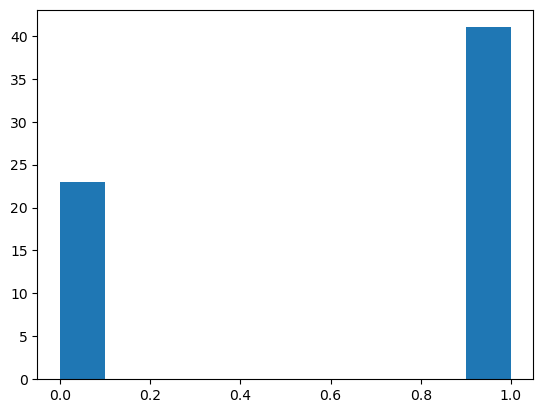

In [179]:
plt.hist(test_score);


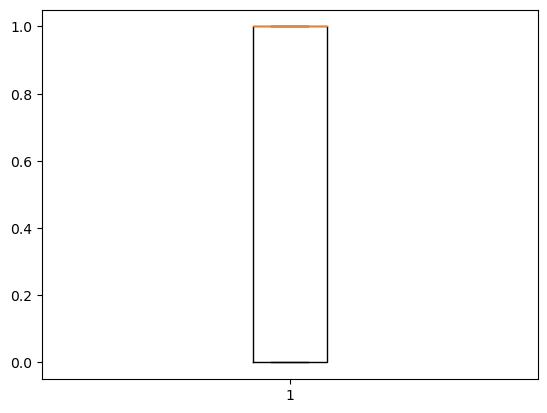

In [180]:
plt.boxplot(test_score);

In [181]:
loss_list_=[]
for i in loss_list:
    loss_list_.append(i.item())

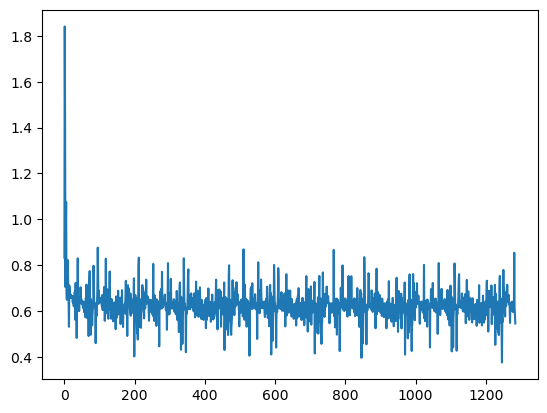

In [182]:
plt.plot(loss_list_)

In [135]:
np.ceil(0.001)

1.0

In [139]:
dataLoader=list(DataLoader(usersGraphDataList,batch_size=80))
avg=[]
for num, data in enumerate(dataLoader):
    ys=data["atom"].y
    unique_values, counts = torch.unique(ys, return_counts=True)
    avg.append(counts[0].item()*100/(counts[0].item()+counts[1].item()))
print( "{} , {:.2f}".format(num,np.mean(avg)))

4 , 39.94


In [140]:
counts[0].item()

18

def train(data):
    model.train()
    optimizer.zero_grad()
    out=model(data.x_dict, data.edge_index_dict)
    #print(out)
    loss=criterion(out['atom'][data['atom'].train_mask],data['atom'].y[data['atom'].train_mask])
    loss.backward()
    optimizer.step()
    pred=out['atom'].argmax(dim=1)
    train_correct=pred[data['atom'].train_mask]==data['atom'].y[data['atom'].train_mask]
    train_acc=int(train_correct.sum())/int(data['atom'].train_mask.sum())
    return loss ,train_acc

def test():
    model.eval()
    out=model(data.x_dict,data.edge_index_dict)
    #print(out)
    pred=out['atom'].argmax(dim=1)
    #print(out)
    test_correct=pred[data['atom'].test_mask]==data['atom'].y[data['atom'].test_mask]
    test_acc=int(test_correct.sum())/int(data['atom'].test_mask.sum())

   
    classificationReport=classification_report(data['atom'].y[data['atom'].test_mask],pred[data['atom'].test_mask])
    print(classificationReport)
    return test_acc

In [141]:
model.eval()
out=model(data.x_dict,data.edge_index_dict)
#print(out)
pred=out['atom'].argmax(dim=1)
#print(out)
test_correct=pred[data['atom'].test_mask]==data['atom'].y[data['atom'].test_mask]
test_acc=int(test_correct.sum())/int(data['atom'].test_mask.sum())
classificationReport=classification_report(data['atom'].y[data['atom'].test_mask],pred[data['atom'].test_mask])
print(classificationReport)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

